In [1]:
import spacy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, Flatten, Embedding, TextVectorization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score
import scikitplot as skplt
import numpy as np
from tqdm.notebook import tqdm_notebook
import time


# Read in raw data

In [2]:
train_df = pd.read_json('../processed_data/train.json')
test_df = pd.read_json('../processed_data/test.json')

train_df = train_df[['text', 'label']]
test_df = test_df[['text', 'label']]

In [3]:
train_df

,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,+
1,Homelessness (or Houselessness as George Carli...,+
2,Brilliant over-acting by Lesley Ann Warren. Be...,+
3,This is easily the most underrated film inn th...,+
4,This is not the typical Mel Brooks film. It wa...,+
...,...,...
24995,"Towards the end of the movie, I felt it was to...",-
24996,This is the kind of movie that my enemies cont...,-
24997,I saw 'Descent' last night at the Stockholm Fi...,-
24998,Some films that you pick up for a pound turn o...,-


In [4]:
train_df = train_df.sample(len(train_df), random_state=42, ignore_index=True)
train_df

,text,label
0,In Panic In The Streets Richard Widmark plays ...,+
1,If you ask me the first one was really better ...,-
2,I am a big fan a Faerie Tale Theatre and I've ...,+
3,I just finished reading a book about Dillinger...,-
4,Greg Davis and Bryan Daly take some crazed sta...,-
...,...,...
24995,My roommates & I nearly shorted out our TV fro...,-
24996,Michelle Rodriguez is the defining actress who...,+
24997,Nice movie with a great soundtrack which spans...,+
24998,"Even though this was a made-for-TV production,...",-


# Storing some important variables

In [5]:
train_len = int(0.8*len(train_df))

max_words=300
embedding_size=300
count_vectorizer = CountVectorizer(max_features=10000)
count_vectorizer.fit(train_df['text'].values)
# For feature 1
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(train_df['text'].values)

# For feature 2
nlp = spacy.load('en_core_web_lg')

# For feature 3
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].values)

#For feature 4
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_words)
vectorizer.adapt(train_df['text'].values)
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

def predict_result(model, x, y_true):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    print(f'f1 : {f1_score(y_true, y_pred)}')
    print(f'acc: {accuracy_score(y_true, y_pred)}')   

In [6]:
def one_hot(row):
    if row == '-':
        return [1, 0]
    else:
        return [0, 1]
    
def get_count_vector_and_one_hot(df):
    x = count_vectorizer.transform(df['text'].values).todense()
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [7]:
train_val_x, train_val_y = get_count_vector_and_one_hot(train_df)
test_x, test_y = get_count_vector_and_one_hot(test_df)

In [8]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

In [9]:
model = Sequential([
    Dense(64, input_shape=(train_x.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_count_ffnn_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()

print(et - st)

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8424
Epoch 1: val_accuracy improved from -inf to 0.88980, saving model to ./models_count_ffnn_raw\checkpoint
625/625 [==============================] - 3s 3ms/step - loss: 0.3789 - accuracy: 0.8425 - val_loss: 0.2738 - val_accuracy: 0.8898
Epoch 2/50
619/625 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9248
Epoch 2: val_accuracy did not improve from 0.88980
625/625 [==============================] - 2s 3ms/step - loss: 0.1986 - accuracy: 0.9250 - val_loss: 0.2833 - val_accuracy: 0.8842
Epoch 3/50
607/625 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9536
Epoch 3: val_accuracy did not improve from 0.88980
625/625 [==============================] - 2s 2ms/step - loss: 0.1264 - accuracy: 0.9536 - val_loss: 0.3382 - val_accuracy: 0.8884
Epoch 4/50
602/625 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.9698
Epoch 4: val_accu

610/625 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9962
Epoch 30: val_accuracy did not improve from 0.88980
625/625 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9962 - val_loss: 0.8255 - val_accuracy: 0.8814
Epoch 31/50
612/625 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9969
Epoch 31: val_accuracy did not improve from 0.88980
625/625 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.8883 - val_accuracy: 0.8848
Epoch 32/50
609/625 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9969
Epoch 32: val_accuracy did not improve from 0.88980
625/625 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.8956 - val_accuracy: 0.8856
Epoch 33/50
598/625 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9966
Epoch 33: val_accuracy did not improve from 0.88980
625/625 [==============

In [11]:
model.load_weights('./models_count_ffnn_raw/checkpoint')

f1 : 1.0
acc: 1.0


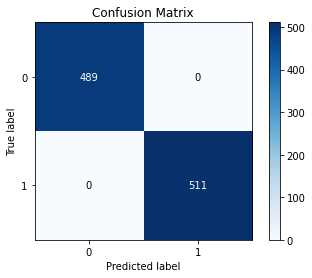

In [12]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8589622447721952
acc: 0.86268


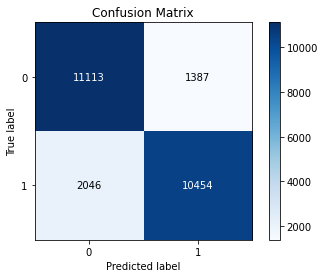

In [13]:
predict_result(model, test_x, test_y)

# Feature 1 (TF-IDF)

In [14]:
def get_tfidf_vector_and_one_hot(df):
    x = tfidf_vectorizer.transform(df['text'].values).todense()
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [15]:
train_val_x, train_val_y = get_tfidf_vector_and_one_hot(train_df)
test_x, test_y = get_tfidf_vector_and_one_hot(test_df)

In [16]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 1 (FFNN w TF-IDF)

In [17]:
model = Sequential([
    Dense(64, input_shape=(train_x.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_tfidf_ffnn_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
619/625 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8510
Epoch 1: val_accuracy improved from -inf to 0.89900, saving model to ./models_tfidf_ffnn_raw\checkpoint
625/625 [==============================] - 2s 3ms/step - loss: 0.3557 - accuracy: 0.8517 - val_loss: 0.2588 - val_accuracy: 0.8990
Epoch 2/50
602/625 [===========================>..] - ETA: 0s - loss: 0.1651 - accuracy: 0.9399
Epoch 2: val_accuracy did not improve from 0.89900
625/625 [==============================] - 1s 2ms/step - loss: 0.1655 - accuracy: 0.9397 - val_loss: 0.2938 - val_accuracy: 0.8852
Epoch 3/50
608/625 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9685
Epoch 3: val_accuracy did not improve from 0.89900
625/625 [==============================] - 2s 3ms/step - loss: 0.0937 - accuracy: 0.9686 - val_loss: 0.3663 - val_accuracy: 0.8824
Epoch 4/50
623/625 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9841
Epoch 4: val_accu

613/625 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9989
Epoch 30: val_accuracy did not improve from 0.89900
625/625 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 1.2228 - val_accuracy: 0.8764
Epoch 31/50
604/625 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 31: val_accuracy did not improve from 0.89900
625/625 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 1.2814 - val_accuracy: 0.8720
Epoch 32/50
612/625 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9987
Epoch 32: val_accuracy did not improve from 0.89900
625/625 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 1.2083 - val_accuracy: 0.8672
Epoch 33/50
617/625 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 33: val_accuracy did not improve from 0.89900
625/625 [==============

In [19]:
model.load_weights('./models_tfidf_ffnn_raw/checkpoint')

f1 : 0.954110898661568
acc: 0.952


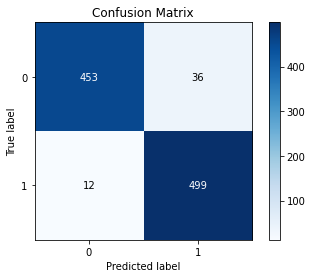

In [20]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8780566022608836
acc: 0.87832


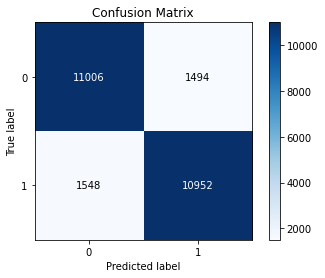

In [21]:
predict_result(model, test_x, test_y)

# Feature 2 (Spacy document vector)

In [22]:
def get_spacy_vector_and_one_hot(df):
    text_list = df['text'].to_list()
    x = []
    for doc in tqdm_notebook(nlp.pipe(text_list, disable=["tagger", "parser", "lemmatizer", 'attribute_ruler', 'ner']),total=len(text_list) ):
        x.append(doc.vector)
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [23]:
train_val_x, train_val_y = get_spacy_vector_and_one_hot(train_df)
test_x, test_y = get_spacy_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

# Splitting training data into train and validation set

In [24]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 2 (FFNN w Spacy Doc Vector)

In [25]:
model = Sequential([
    Dense(512, input_shape=(300,), activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_spacy_ffnn_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               154112    
                                                                 
 dense_7 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1,205,250
Trainable params: 1,205,250
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
611/625 [============================>.] - ETA: 0s - loss: 0.4284 - accuracy: 0.7993
Epoch 1: val_accuracy improved from -inf to 0.84540, saving model to ./models_spacy_ffnn_raw\checkpoint
625/625 [==============================] - 2s 3ms/step - loss: 0.4270 - accuracy: 0.8005 - val_loss: 0.3697 - val_accuracy: 0.8454
Epoch 2/50
621/625 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8388
Epoch 2: val_accuracy improved from 0.84540 to 0.85720, saving model to ./models_spacy_ffnn_raw\checkpoint
625/625 [==============================] - 2s 3ms/step - loss: 0.3667 - accuracy: 0.8388 - val_loss: 0.3430 - val_accuracy: 0.8572
Epoch 3/50
599/625 [===========================>..] - ETA: 0s - loss: 0.3550 - accuracy: 0.8468
Epoch 3: val_accuracy did not improve from 0.85720
625/625 [==============================] - 1s 2ms/step - loss: 0.3559 - accuracy: 0.8464 - val_loss: 0.3774 - val_accuracy: 0.8300
Epoch 4/50
601/625 [===========================>..] - ETA

606/625 [============================>.] - ETA: 0s - loss: 0.2480 - accuracy: 0.8967
Epoch 29: val_accuracy did not improve from 0.86900
625/625 [==============================] - 1s 2ms/step - loss: 0.2478 - accuracy: 0.8966 - val_loss: 0.3928 - val_accuracy: 0.8562
Epoch 30/50
614/625 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 0.8953
Epoch 30: val_accuracy did not improve from 0.86900
625/625 [==============================] - 1s 2ms/step - loss: 0.2489 - accuracy: 0.8951 - val_loss: 0.3755 - val_accuracy: 0.8542
Epoch 31/50
604/625 [===========================>..] - ETA: 0s - loss: 0.2419 - accuracy: 0.9006
Epoch 31: val_accuracy did not improve from 0.86900
625/625 [==============================] - 1s 2ms/step - loss: 0.2420 - accuracy: 0.9003 - val_loss: 0.3807 - val_accuracy: 0.8552
Epoch 32/50
609/625 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9021
Epoch 32: val_accuracy did not improve from 0.86900
625/625 [==============

In [27]:
model.load_weights('./models_spacy_ffnn_raw/checkpoint')

f1 : 0.8815533980582524
acc: 0.878


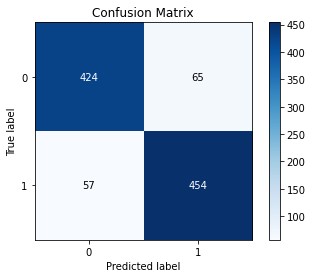

In [28]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8541417999522559
acc: 0.85336


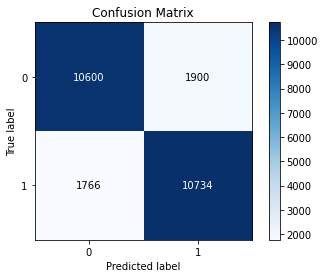

In [29]:
predict_result(model, test_x, test_y)

# Feature 3 (Text to Sequences)

In [30]:
def get_sequences_and_one_hot(df):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    x = pad_sequences(sequences, maxlen=max_words)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [31]:
train_val_x, train_val_y = get_sequences_and_one_hot(train_df)
test_x, test_y = get_sequences_and_one_hot(test_df)

In [32]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 3 (LSTM)

In [33]:
model = Sequential([
    Embedding(512, embedding_size, input_length=max_words),
    LSTM(512),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_lstm_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          153600    
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1,851,586
Trainable params: 1,851,586
No

In [34]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.6843
Epoch 1: val_accuracy improved from -inf to 0.75140, saving model to ./models_t2s_lstm_raw\checkpoint
625/625 [==============================] - 22s 32ms/step - loss: 0.5922 - accuracy: 0.6844 - val_loss: 0.5611 - val_accuracy: 0.7514
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.6690
Epoch 2: val_accuracy did not improve from 0.75140
625/625 [==============================] - 20s 32ms/step - loss: 0.5996 - accuracy: 0.6690 - val_loss: 0.6931 - val_accuracy: 0.5076
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5120
Epoch 3: val_accuracy did not improve from 0.75140
625/625 [==============================] - 20s 32ms/step - loss: 0.6923 - accuracy: 0.5120 - val_loss: 0.6898 - val_accuracy: 0.5092
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.6118
Epoch 4: val_

625/625 [==============================] - 21s 33ms/step - loss: 0.1377 - accuracy: 0.9456 - val_loss: 0.7748 - val_accuracy: 0.8240
Epoch 29/50
625/625 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9517
Epoch 29: val_accuracy did not improve from 0.84920
625/625 [==============================] - 20s 32ms/step - loss: 0.1234 - accuracy: 0.9517 - val_loss: 0.6203 - val_accuracy: 0.8270
Epoch 30/50
625/625 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9578
Epoch 30: val_accuracy did not improve from 0.84920
625/625 [==============================] - 20s 31ms/step - loss: 0.1109 - accuracy: 0.9578 - val_loss: 0.6469 - val_accuracy: 0.8322
Epoch 31/50
625/625 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9588
Epoch 31: val_accuracy did not improve from 0.84920
625/625 [==============================] - 20s 32ms/step - loss: 0.1069 - accuracy: 0.9588 - val_loss: 0.7123 - val_accuracy: 0.8278
Epoch 32/50
625/625 [

In [35]:
model.load_weights('./models_t2s_lstm_raw/checkpoint')

f1 : 0.9034146341463415
acc: 0.901


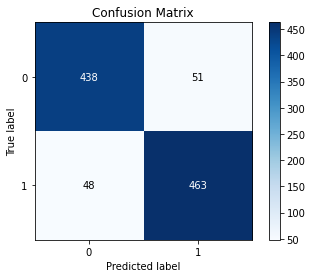

In [36]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8506003021388248
acc: 0.84968


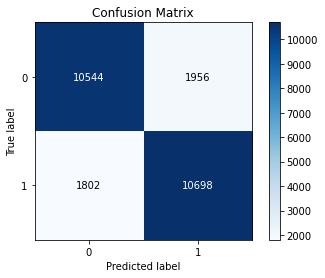

In [37]:
predict_result(model, test_x, test_y)

# Model 4 (Bi-LSTM)

In [38]:
model = Sequential([
    Embedding(512, embedding_size, input_length=max_words),
    Bidirectional(LSTM(256)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_bilstm_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          153600    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1140736   
 l)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                      

In [39]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6786
Epoch 1: val_accuracy improved from -inf to 0.78520, saving model to ./models_t2s_bilstm_raw\checkpoint
625/625 [==============================] - 31s 47ms/step - loss: 0.6032 - accuracy: 0.6786 - val_loss: 0.5003 - val_accuracy: 0.7852
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7632
Epoch 2: val_accuracy did not improve from 0.78520
625/625 [==============================] - 28s 44ms/step - loss: 0.5129 - accuracy: 0.7632 - val_loss: 0.6711 - val_accuracy: 0.5320
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 0.5450 - accuracy: 0.7204
Epoch 3: val_accuracy did not improve from 0.78520
625/625 [==============================] - 29s 47ms/step - loss: 0.5447 - accuracy: 0.7206 - val_loss: 0.4973 - val_accuracy: 0.7516
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.4734 - accuracy: 0.7829
Epoch 4: va

Epoch 29/50
624/625 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9796
Epoch 29: val_accuracy did not improve from 0.85240
625/625 [==============================] - 28s 46ms/step - loss: 0.0601 - accuracy: 0.9796 - val_loss: 0.8575 - val_accuracy: 0.8336
Epoch 30/50
624/625 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9822
Epoch 30: val_accuracy did not improve from 0.85240
625/625 [==============================] - 27s 44ms/step - loss: 0.0516 - accuracy: 0.9822 - val_loss: 0.8283 - val_accuracy: 0.8332
Epoch 31/50
624/625 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9834
Epoch 31: val_accuracy did not improve from 0.85240
625/625 [==============================] - 30s 48ms/step - loss: 0.0487 - accuracy: 0.9833 - val_loss: 0.9245 - val_accuracy: 0.8298
Epoch 32/50
624/625 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9870
Epoch 32: val_accuracy did not improve from 0.85240
625/6

In [40]:
model.load_weights('./models_t2s_bilstm_raw/checkpoint')

f1 : 0.8980392156862744
acc: 0.896


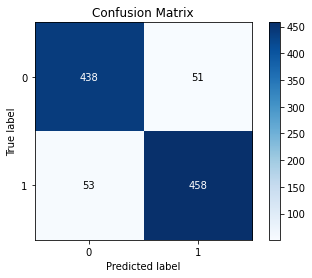

In [41]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8524193548387096
acc: 0.8536


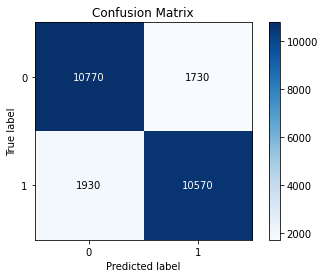

In [42]:
predict_result(model, test_x, test_y)

# Feature 3 (Glove Embeddings)

In [43]:
path = './glove.42B.300d/glove.42B.300d.txt'
embeddings_index = {}

with open(path, encoding='utf8') as f:
    for line in tqdm_notebook(f):
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, 'f', sep=' ')
        embeddings_index[word] = coef
        
len(embeddings_index)

0it [00:00, ?it/s]

1917494

In [44]:
embedding_dim = 300

num_tokens = len(vocab) + 2

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19141 words (859 misses)


In [45]:
def get_vector_and_one_hot(df):
    x = vectorizer(np.array([[s] for s in tqdm_notebook(df['text'])])).numpy() 
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [46]:
train_val_x, train_val_y = get_vector_and_one_hot(train_df)
test_x, test_y = get_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [47]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 4 

In [48]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Dense(256, activation="relu")(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_ffnn_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         6000600   
                                                                 
 dense_14 (Dense)            (None, None, 256)         77056     
                                                                 
 dropout_9 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_15 (Dense)            (None, None, 256)         65792     
                                                                 
 dropout_10 (Dropout)        (None, None, 256)         0         
                                                                 
 dense_16 (Dense)            (None, None, 256)         65792 

In [49]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
615/625 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.7637
Epoch 1: val_accuracy improved from -inf to 0.83600, saving model to ./models_glove_ffnn_raw\checkpoint
625/625 [==============================] - 4s 5ms/step - loss: 0.4682 - accuracy: 0.7649 - val_loss: 0.4697 - val_accuracy: 0.8360
Epoch 2/50
616/625 [============================>.] - ETA: 0s - loss: 0.3804 - accuracy: 0.8349
Epoch 2: val_accuracy did not improve from 0.83600
625/625 [==============================] - 3s 4ms/step - loss: 0.3805 - accuracy: 0.8349 - val_loss: 0.4702 - val_accuracy: 0.8342
Epoch 3/50
612/625 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.8472
Epoch 3: val_accuracy did not improve from 0.83600
625/625 [==============================] - 3s 4ms/step - loss: 0.3541 - accuracy: 0.8475 - val_loss: 0.4908 - val_accuracy: 0.7846
Epoch 4/50
623/625 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.8555
Epoch 4: val_accu

Epoch 30/50
616/625 [============================>.] - ETA: 0s - loss: 0.1995 - accuracy: 0.9185
Epoch 30: val_accuracy did not improve from 0.84720
625/625 [==============================] - 3s 4ms/step - loss: 0.1992 - accuracy: 0.9186 - val_loss: 0.4013 - val_accuracy: 0.8174
Epoch 31/50
617/625 [============================>.] - ETA: 0s - loss: 0.2024 - accuracy: 0.9150
Epoch 31: val_accuracy did not improve from 0.84720
625/625 [==============================] - 3s 4ms/step - loss: 0.2024 - accuracy: 0.9150 - val_loss: 0.4038 - val_accuracy: 0.8186
Epoch 32/50
613/625 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9202
Epoch 32: val_accuracy did not improve from 0.84720
625/625 [==============================] - 3s 4ms/step - loss: 0.1944 - accuracy: 0.9199 - val_loss: 0.3845 - val_accuracy: 0.8386
Epoch 33/50
615/625 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9200
Epoch 33: val_accuracy did not improve from 0.84720
625/625 [==

In [50]:
model.load_weights('./models_glove_ffnn_raw/checkpoint')

f1 : 0.9622266401590458
acc: 0.962


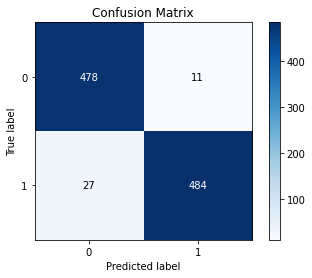

In [51]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8163948138854036
acc: 0.8244


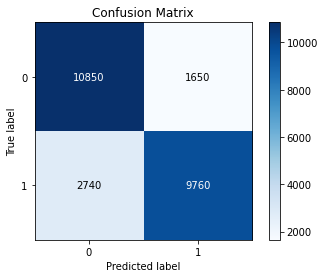

In [52]:
predict_result(model, test_x, test_y)

In [53]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Bidirectional(LSTM(128))(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Flatten()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_bilstm_raw/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 300)         6000600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                           

In [54]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')
st = time.time()
model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)
et = time.time()
print(et - st)

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6594
Epoch 1: val_accuracy improved from -inf to 0.79880, saving model to ./models_glove_bilstm_raw\checkpoint
625/625 [==============================] - 29s 45ms/step - loss: 0.6228 - accuracy: 0.6594 - val_loss: 0.4599 - val_accuracy: 0.7988
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8406
Epoch 2: val_accuracy improved from 0.79880 to 0.86500, saving model to ./models_glove_bilstm_raw\checkpoint
625/625 [==============================] - 27s 44ms/step - loss: 0.3810 - accuracy: 0.8406 - val_loss: 0.3339 - val_accuracy: 0.8650
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8694
Epoch 3: val_accuracy did not improve from 0.86500
625/625 [==============================] - 29s 46ms/step - loss: 0.3150 - accuracy: 0.8694 - val_loss: 0.3402 - val_accuracy: 0.8584
Epoch 4/50
624/625 [===========================

Epoch 29/50
625/625 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9962
Epoch 29: val_accuracy did not improve from 0.88700
625/625 [==============================] - 27s 44ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.8460 - val_accuracy: 0.8840
Epoch 30/50
624/625 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9944
Epoch 30: val_accuracy did not improve from 0.88700
625/625 [==============================] - 27s 43ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.8454 - val_accuracy: 0.8806
Epoch 31/50
625/625 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9954
Epoch 31: val_accuracy did not improve from 0.88700
625/625 [==============================] - 28s 44ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.7783 - val_accuracy: 0.8806
Epoch 32/50
625/625 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9965
Epoch 32: val_accuracy did not improve from 0.88700
625/6

In [55]:
model.load_weights('./models_glove_bilstm_raw/checkpoint')

f1 : 0.9439528023598821
acc: 0.943


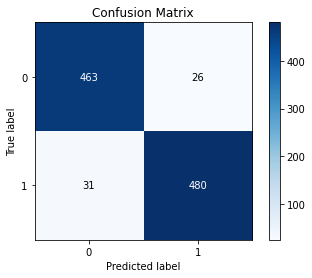

In [56]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8808707921789961
acc: 0.8818


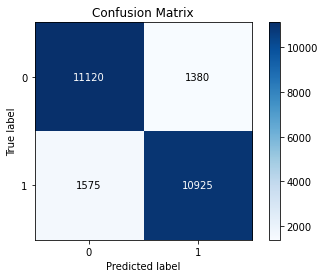

In [57]:
predict_result(model, test_x, test_y)